In [1]:
import numpy as np
import scipy as sp
import pandas as pd

from scipy import optimize

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

N= 10000



def S_ref(A,B,E):
    return (E/A)**(1/B)


def S_i(alpha, beta, delta, cos, f):
    cos_ref=np.cos(38*np.pi/180.)**2
    x = cos-cos_ref
    return f*(delta+beta*x+alpha*x**2)

def S_i_fit(cos, alpha, beta, f):
    cos_ref=np.cos(38*np.pi/180.)**2
    x = cos-cos_ref
    return f*(alpha*x**2+beta*x+1)


def get_random_vars(N):
    E0 = 10**15
    E1 = 10**18
    gamma = -2.5

    A = 10**12
    B = 1.2
    b=0.919
    a=-1.13
    c=1

    E = rndm(E0, E1, gamma, N) 
    
    S_i_ref=S_ref(A,B,E)
    cos_2 = np.random.rand(N)
    S=S_i(a,b,c,cos_2,S_i_ref)
    data=pd.DataFrame()
    data['E'] = E
    data['S_ref'] = S_i_ref
    data['cos2'] = cos_2
    data['S'] = S
    data['th'] = np.arccos(np.sqrt(data.cos2))
    data['lgE'] = np.log10(data.E)
    data['lgS'] = np.log10(data.S)
    data['lgS_ref'] = np.log10(data.S_ref)
    data = data.sort_values(['lgS'])
    data['I'] = 0
    bins = np.linspace(0, 1, 11, endpoint = True )
    ind = np.digitize(data['cos2'],bins)
    groups = data.groupby(ind)
                      
    for name, group in groups:
        values = group['lgS'].apply(lambda x: group[group['lgS']>x].count())
        data.loc[group.I.index.tolist(), 'I']= values.I 
        
    data['sqrt_I']=np.sqrt(data.I)
    return data



In [3]:
m=10
ref_intensity= 50
#data=pd.DataFrame.clear
#print(type(data))
for i in range(0,m): 
    mydata = get_random_vars(10000)
    val = mydata.loc[mydata.I == ref_intensity]
    delta_up = mydata.loc[mydata.I== mydata.I+mydata.sqrt_I]
    delta_down = mydata.loc[mydata.I== mydata.I-mydata.sqrt_I]
    delta_Scal = delta_down.S-delta_up.S
    
    mydata.drop(mydata.index,  inplace=True)
    #print(mydata.S.std())
    
print(type(mydata.index))

/home/noemie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log10


<class 'pandas.core.indexes.numeric.Int64Index'>


In [5]:
bins2=np.linspace(0.05,0.95,10, endpoint = True)
att_fit2, cov2 =sp.optimize.curve_fit(S_i_fit, bins2, val.S)
data_up=mydata.I+mydata.sqrt_I
print(delta_up)   #it seems like there are no values corresponding to the intensity with error
print(mydata.I-mydata.sqrt_I)

                 E         S_ref      cos2            S        th        lgE  \
418   6.469695e+16  10211.036429  0.038797   837.486209  1.372530  16.810884   
2552  1.880076e+16   3645.967987  0.162698  1245.285046  1.155612  16.274175   
6563  1.198436e+16   2505.218807  0.295303  1455.231579  0.996293  16.078615   
3544  1.598164e+16   3184.328373  0.405471  2386.630841  0.880499  16.203621   
9227  1.202102e+16   2511.603675  0.707985  2690.975698  0.570894  16.079941   
7970  2.174188e+16   4115.421068  0.384298  2959.877741  0.902158  16.337297   
6574  1.601066e+16   3189.146042  0.609136  3153.984181  0.675377  16.204409   
2927  1.786230e+16   3493.663360  0.531548  3175.025449  0.753829  16.251937   
4933  1.550397e+16   3104.816056  0.957106  3667.516099  0.208620  16.190443   
8099  3.060726e+16   5472.516312  0.874201  6349.542294  0.362574  16.485824   
494   1.573256e+15    461.317034  0.001521    -1.315716  1.531782  15.196799   
1302  1.783037e+15    512.035731  0.0006

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


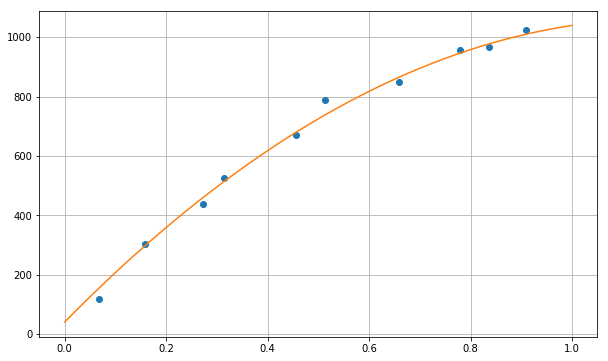

0.6209609477998339


In [5]:
fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
bins=np.linspace(0.0, 1, val.S.size)
bins2=np.linspace(0.05,0.95,10, endpoint = True)

print(bins2)

att_fit2, cov2 =sp.optimize.curve_fit(S_i_fit, bins2, val.S)

x=np.linspace(0,1, 1000)
ax2.plot(val.cos2, val.S, lw=0, marker='o')
ax2.plot(x, S_i_fit(x,att_fit2[0],att_fit2[1],att_fit2[2]))
cos_ref = np.cos(38.*np.pi/180.)**2


plt.show()
print(cos_ref)

In [6]:
print(att_fit2, cov2)
print(np.sqrt(np.diag(cov2)))

[ -0.88518014   0.98094675 835.52477083] [[ 1.00240578e-02  3.28842295e-03 -5.49556759e-01]
 [ 3.28842295e-03  1.69222473e-03 -1.81905133e-01]
 [-5.49556759e-01 -1.81905133e-01  8.52546504e+01]]
[0.10012022 0.04113666 9.23334449]


In [ ]:
#gaussian smearing (10-15%)
sigma=np.sqrt(0.1)
N=len(val.S)
gauss=np.zeros(N)

print(np.random.normal(val.S, sigma))
def gauss_distrib(mu, sigma):
    for i in range(0,N):
        m=mu[i]
        gauss[i]=np.random.normal(m,sigma)
    return gauss
print(gauss_distrib(val.S, sigma))

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
bins2=np.linspace(15, 17, 20)

sel_data = data.loc[data.cos2>0.]
sel_data = sel_data.loc[sel_data.cos2<0.2]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.-0.2", ec='white')

sel_data = data.loc[data.cos2>0.2]
sel_data = sel_data.loc[sel_data.cos2<0.4]
#n4, bins5, patches = ax2.hist(data.lgE,bins = 100, normed = False, label="Histogram", ec='white')
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.2-0.4", ec='white')


sel_data= data.loc[data.cos2>0.4]
sel_data=sel_data.loc[sel_data.cos2<0.6]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.4-0.6", ec='white')

sel_data = data.loc[data.cos2>0.6]
sel_data = sel_data.loc[sel_data.cos2<0.8]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.6-0.8", ec='white')


sel_data = data.loc[data.cos2>0.8]
sel_data = sel_data.loc[sel_data.cos2<1.]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.8-1", ec='white')

ax2.set_xlabel("lg (E/eV)")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.legend()
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(figsize=(16,10))
#plt.grid()
bins=np.linspace(2.5, 4, 50)

#sel_data = data.loc[data.cos2>0.]
#sel_data = sel_data.loc[sel_data.cos2<0.2]
#ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.-0.2", ec='white')

sel_data = data.loc[data.cos2>0.2]
sel_data = sel_data.loc[sel_data.cos2<0.4]
#n4, bins5, patches = ax2.hist(data.lgE,bins = 100, normed = False, label="Histogram", ec='white')
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.2-0.4", ec='white')


sel_data= data.loc[data.cos2>0.4]
sel_data=sel_data.loc[sel_data.cos2<0.6]
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.4-0.6", ec='white')

sel_data = data.loc[data.cos2>0.6]
sel_data = sel_data.loc[sel_data.cos2<0.8]
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.6-0.8", ec='white')


sel_data = data.loc[data.cos2>0.8]
sel_data = sel_data.loc[sel_data.cos2<1.]
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.8-1", ec='white')

ax2.set_xlabel("lg (E/eV)")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.legend()
plt.show()

In [ ]:
def fit_powerlow(x, a, b):
    return a*(10**(x-15))**b
n= n[np.where(n>10)]

bins2=bins[np.where(n>10)]
from scipy.optimize import curve_fit

pars, cov = curve_fit(fit_powerlow, bins2, n , p0=[1000, 1.5])
print(pars)

fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.plot(bins2, n)
ax2.plot(bins2, fit_powerlow(bins2, *pars), lw=4, label="Fit_powerlow")
ax2.set_xlabel("log10(E/eV)-18")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
ax2.legend()
plt.show()

In [ ]:
def fit_Si(x, a, gamma):
     return a*(10**(x-2.5))**(gamma)

n2=n2[np.where(n2>0)]
bins3=bins3[np.where(n2>0)]
pars2, cov2 = curve_fit(fit_Si, bins3, n2 , p0=[100, -1.2])
print(pars2, cov2)

fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
n2, bins3, patches = ax2.hist(np.log10(S_i_ref),bins = 100, normed = False, label="Histogram", ec='white') #plot the data in a histogram with 100 bins

ax2.plot(bins3, fit_Si(bins3, *pars2) , lw=4, label="Fit_Si")
ax2.set_xlabel("X")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.legend()
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data.cos2, bins=10)
ax2.legend()
plt.show()